In [1]:
import random  # noqa E402

import matplotlib.pyplot as plt  # noqa E402
import networkx as nx  # noqa E402

import autogen  # noqa E402
from autogen.agentchat.conversable_agent import ConversableAgent  # noqa E402
from autogen.agentchat.assistant_agent import AssistantAgent  # noqa E402
from autogen.agentchat.groupchat import GroupChat  # noqa E402
from autogen.graph_utils import visualize_speaker_transitions_dict  # noqa E402

In [2]:
config_list = [
  {
    "model": "codellama",
    "base_url": "http://localhost:11434/v1",
    "api_key": "ollama",
  }
]
config_list_llama = {
    "timeout": 600,
    "cache_seed": 44,  # change the seed for different trials
    "config_list": config_list,
    "temperature": 0,
}

In [3]:
def get_agent_of_name(agents, name) -> ConversableAgent:
    for agent in agents:
        if agent.name == name:
            return agent

speaker_transitions_dict: {<autogen.agentchat.assistant_agent.AssistantAgent object at 0x7f961c9d89d0>: [<autogen.agentchat.assistant_agent.AssistantAgent object at 0x7f961c00dbd0>, <autogen.agentchat.assistant_agent.AssistantAgent object at 0x7f961be55fd0>, <autogen.agentchat.assistant_agent.AssistantAgent object at 0x7f961be23a50>, <autogen.agentchat.assistant_agent.AssistantAgent object at 0x7f961be80710>], <autogen.agentchat.assistant_agent.AssistantAgent object at 0x7f961c00dbd0>: [<autogen.agentchat.assistant_agent.AssistantAgent object at 0x7f961c9d89d0>, <autogen.agentchat.assistant_agent.AssistantAgent object at 0x7f961be55fd0>], <autogen.agentchat.assistant_agent.AssistantAgent object at 0x7f961be55fd0>: [<autogen.agentchat.assistant_agent.AssistantAgent object at 0x7f961c9d89d0>, <autogen.agentchat.assistant_agent.AssistantAgent object at 0x7f961c00dbd0>], <autogen.agentchat.assistant_agent.AssistantAgent object at 0x7f961be23a50>: [<autogen.agentchat.assistant_agent.Assista

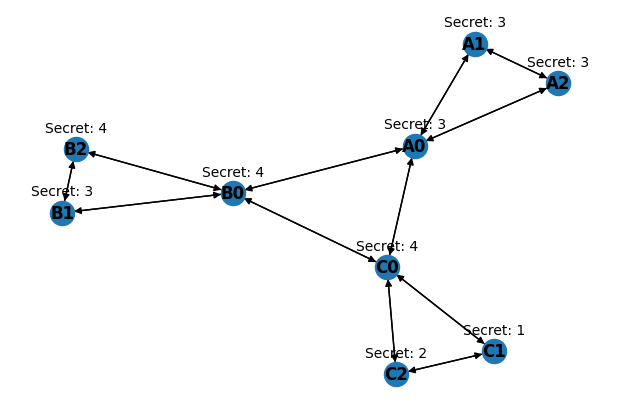

In [10]:
agents = []
speaker_transitions_dict = {}
secret_values = {}

# Outer loop for prefixes 'A', 'B', 'C'
for prefix in ["A", "B", "C"]:
    # Add 3 nodes with each prefix to the graph using a for loop
    for i in range(3):
        node_id = f"{prefix}{i}"
        secret_value = random.randint(1, 5)  # Generate a random secret value
        secret_values[node_id] = secret_value

        # Create an AssistantAgent for each node (assuming AssistantAgent is a defined class)
        agents.append(
            AssistantAgent(
                name=node_id,
                system_message=f"""Your name is {node_id}.
                                          Do not respond as the speaker named in the NEXT tag if your name is not in the NEXT tag. Instead, suggest a relevant team leader to handle the mis-tag, with the NEXT: tag.

                                          You have {secret_value} chocolates.

                                          The list of players are [A0, A1, A2, B0, B1, B2, C0, C1, C2].

                                            Your first character of your name is your team, and your second character denotes that you are a team leader if it is 0.
                                            CONSTRAINTS: Team members can only talk within the team, whilst team leader can talk to team leaders of other teams but not team members of other teams.

                                            You can use NEXT: to suggest the next speaker. You have to respect the CONSTRAINTS, and can only suggest one player from the list of players, i.e., do not suggest A3 because A3 is not from the list of players.
                                            Team leaders must make sure that they know the sum of the individual chocolate count of all three players in their own team, i.e., A0 is responsible for team A only.

                                          Keep track of the player's tally using a JSON format so that others can check the total tally. Use
                                          A0:?, A1:?, A2:?,
                                          B0:?, B1:?, B2:?,
                                          C0:?, C1:?, C2:?

                                          If you are the team leader, you should aggregate your team's total chocolate count to cooperate.
                                          Once the team leader know their team's tally, they can suggest another team leader for them to find their team tally, because we need all three team tallys to succeed.
                                          Use NEXT: to suggest the next speaker, e.g., NEXT: A0.

                                          Once we have the total tally from all nine players, sum up all three teams' tally, then terminate the discussion using TERMINATE.

                                          """,
                llm_config=config_list_llama,
            )
        )
        speaker_transitions_dict[agents[-1]] = []

    # Add edges between nodes with the same prefix using a nested for loop
    for source_node in range(3):
        source_id = f"{prefix}{source_node}"
        for target_node in range(3):
            target_id = f"{prefix}{target_node}"
            if source_node != target_node:  # To avoid self-loops
                speaker_transitions_dict[get_agent_of_name(agents, source_id)].append(
                    get_agent_of_name(agents, name=target_id)
                )
# Adding edges between teams
speaker_transitions_dict[get_agent_of_name(agents, "A0")].append(get_agent_of_name(agents, name="B0"))
speaker_transitions_dict[get_agent_of_name(agents, "A0")].append(get_agent_of_name(agents, name="C0"))
speaker_transitions_dict[get_agent_of_name(agents, "B0")].append(get_agent_of_name(agents, name="A0"))
speaker_transitions_dict[get_agent_of_name(agents, "B0")].append(get_agent_of_name(agents, name="C0"))
speaker_transitions_dict[get_agent_of_name(agents, "C0")].append(get_agent_of_name(agents, name="A0"))
speaker_transitions_dict[get_agent_of_name(agents, "C0")].append(get_agent_of_name(agents, name="B0"))

# Visualization only
graph = nx.DiGraph()

graph.add_nodes_from([agent.name for agent in agents])

# Add edges
for key, value in speaker_transitions_dict.items():
    for agent in value:
        graph.add_edge(key.name, agent.name)

# Visualize
# Draw the graph with secret values annotated
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(graph)  # positions for all nodes
nx.draw(graph, pos, with_labels=True, font_weight="bold")
# Annotate secret values
for node, (x, y) in pos.items():
    secret_value = secret_values[node]
    plt.text(x, y + 0.1, s=f"Secret: {secret_value}", horizontalalignment="center")
print("speaker_transitions_dict:",speaker_transitions_dict)
plt.show()

In [11]:
def is_termination_msg(content) -> bool:
    have_content = content.get("content", None) is not None
    if have_content and "TERMINATE" in content["content"]:
        return True
    return False


# Terminates the conversation when TERMINATE is detected.
user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="Terminator admin.",
    code_execution_config=False,
    is_termination_msg=is_termination_msg,
    human_input_mode="NEVER",
)

agents.append(user_proxy)

In [13]:
group_chat = GroupChat(
    agents=agents,
    messages=[],
    max_round=20,
    allowed_or_disallowed_speaker_transitions=speaker_transitions_dict,
    speaker_transitions_type="allowed",
)


# Create the manager
manager = autogen.GroupChatManager(
    groupchat=group_chat,
    llm_config=config_list_llama,
    code_execution_config=False,
    is_termination_msg=is_termination_msg,
)


# Initiates the chat with Alice
agents[0].initiate_chat(
    manager,
    message="""
                        There are 9 players in this game, split equally into Teams A, B, C. Therefore each team has 3 players, including the team leader.
                        The task is to find out the sum of chocolate count from all nine players. I will now start with my team.
                        NEXT: A1""",
)

A0 (to chat_manager):


                        There are 9 players in this game, split equally into Teams A, B, C. Therefore each team has 3 players, including the team leader.
                        The task is to find out the sum of chocolate count from all nine players. I will now start with my team.
                        NEXT: A1

--------------------------------------------------------------------------------
[autogen.oai.client: 10-14 03:33:26] {351} WARNING - Model codellama is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.



Next speaker: A2

[autogen.oai.client: 10-14 03:33:26] {351} WARNING - Model codellama is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.


A2 (to chat_manager):


A1, you have 3 chocolates.

A0:?, A1:3, A2:?,
B0:?, B1:?, B2:?,
C0:?, C1:?, C2:?

NEXT: A2

--------------------------------------------------------------------------------
[autogen.oai.client: 10-14 03:33:27] {351} WARNING - Model codellama is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.



Next speaker: A0

[autogen.oai.client: 10-14 03:33:28] {351} WARNING - Model codellama is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.


A0 (to chat_manager):


A2, you have 3 chocolates.

A0:?, A1:3, A2:3,
B0:?, B1:?, B2:?,
C0:?, C1:?, C2:?

NEXT: B0

--------------------------------------------------------------------------------
[autogen.oai.client: 10-14 03:33:28] {351} WARNING - Model codellama is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.



Next speaker: A2

[autogen.oai.client: 10-14 03:33:29] {351} WARNING - Model codellama is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.


A2 (to chat_manager):



B0, you have 3 chocolates.

A0:?, A1:3, A2:3,
B0:3, B1:?, B2:?,
C0:?, C1:?, C2:?

NEXT: C0

--------------------------------------------------------------------------------
[autogen.oai.client: 10-14 03:33:29] {351} WARNING - Model codellama is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.



Next speaker: A0

[autogen.oai.client: 10-14 03:33:30] {351} WARNING - Model codellama is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.


A0 (to chat_manager):


C0, you have 3 chocolates.

A0:?, A1:3, A2:3,
B0:3, B1:?, B2:?,
C0:3, C1:?, C2:?

NEXT: A0

--------------------------------------------------------------------------------
[autogen.oai.client: 10-14 03:33:31] {351} WARNING - Model codellama is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.



Next speaker: A2

[autogen.oai.client: 10-14 03:33:32] {351} WARNING - Model codellama is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.


A2 (to chat_manager):



A0, you have 3 chocolates.

A0:3, A1:3, A2:3,
B0:3, B1:?, B2:?,
C0:3, C1:?, C2:?

NEXT: B1

--------------------------------------------------------------------------------
[autogen.oai.client: 10-14 03:33:32] {351} WARNING - Model codellama is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.



Next speaker: A1

[autogen.oai.client: 10-14 03:33:33] {351} WARNING - Model codellama is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.


A1 (to chat_manager):


B1, you have 3 chocolates.

A0:3, A1:3, A2:3,
B0:3, B1:3, B2:?,
C0:3, C1:?, C2:?

NEXT: C1

--------------------------------------------------------------------------------
[autogen.oai.client: 10-14 03:33:34] {351} WARNING - Model codellama is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.



Next speaker: A2

[autogen.oai.client: 10-14 03:33:35] {351} WARNING - Model codellama is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.


A2 (to chat_manager):



C1, you have 3 chocolates.

A0:3, A1:3, A2:3,
B0:3, B1:3, B2:?,
C0:3, C1:3, C2:?

NEXT: A2

--------------------------------------------------------------------------------
[autogen.oai.client: 10-14 03:33:36] {351} WARNING - Model codellama is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.



Next speaker: A0

[autogen.oai.client: 10-14 03:33:39] {351} WARNING - Model codellama is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.


A0 (to chat_manager):


A2, you have 3 chocolates.

A0:3, A1:3, A2:6,
B0:3, B1:3, B2:?,
C0:3, C1:3, C2:?

NEXT: B2


B2, you have 3 chocolates.

A0:3, A1:3, A2:6,
B0:3, B1:3, B2:3,
C0:3, C1:3, C2:?

NEXT: C2



C2, you have 3 chocolates.

A0:3, A1:3, A2:6,
B0:3, B1:3, B2:3,
C0:3, C1:3, C2:3

NEXT: TERMINATE

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': '\n                        There are 9 players in this game, split equally into Teams A, B, C. Therefore each team has 3 players, including the team leader.\n                        The task is to find out the sum of chocolate count from all nine players. I will now start with my team.\n                        NEXT: A1', 'role': 'assistant', 'name': 'A0'}, {'content': '\nA1, you have 3 chocolates.\n\nA0:?, A1:3, A2:?,\nB0:?, B1:?, B2:?,\nC0:?, C1:?, C2:?\n\nNEXT: A2', 'name': 'A2', 'role': 'user'}, {'content': '\nA2, you have 3 chocolates.\n\nA0:?, A1:3, A2:3,\nB0:?, B1:?, B2:?,\nC0:?, C1:?, C2:?\n\nNEXT: B0', 'role': 'assistant', 'name': 'A0'}, {'content': '\n\nB0, you have 3 chocolates.\n\nA0:?, A1:3, A2:3,\nB0:3, B1:?, B2:?,\nC0:?, C1:?, C2:?\n\nNEXT: C0', 'name': 'A2', 'role': 'user'}, {'content': '\nC0, you have 3 chocolates.\n\nA0:?, A1:3, A2:3,\nB0:3, B1:?, B2:?,\nC0:3, C1:?, C2:?\n\nNEXT: A0', 'role': 'assistant', 'name': 'A0'}